In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

from Features import *



In [2]:
edf=pd.read_csv('ReadyData/EURUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)
gdf=pd.read_csv('ReadyData/GBPUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)

In [3]:
edf.info()
gdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98992 entries, 2020-01-02 00:15:00 to 2023-12-20 12:45:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       98992 non-null  float64
 1   high       98992 non-null  float64
 2   low        98992 non-null  float64
 3   close      98992 non-null  float64
 4   volume     98992 non-null  int64  
 5   low_time   98989 non-null  object 
 6   high_time  98989 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 6.0+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99610 entries, 2020-01-02 00:15:00 to 2023-12-29 23:30:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       99610 non-null  float64
 1   high       99610 non-null  float64
 2   low        99610 non-null  float64
 3   close      99610 non-null  float64
 4   volume     99610 non-null  int64  
 5   low_tim

In [20]:
merged_df = pd.merge(edf, gdf, left_index=True, right_index=True, suffixes=('edf', 'gdf'), how='outer')


In [21]:
merged_df['returnedf'] = merged_df['closeedf'].pct_change(1)
merged_df['returngdf'] = merged_df['closegdf'].pct_change(1)

merged_df ['diff'] = merged_df['closeedf'] - merged_df['closegdf']

# Calculate the rolling mean and standard deviation for 'diff'
window = 20  # Define the window size for rolling calculations
merged_df['diff_mean'] = merged_df['diff'].rolling(window=window).mean()
merged_df['diff_std'] = merged_df['diff'].rolling(window=window).std()

# Calculate upper and lower Bollinger Bands
merged_df['upper_band'] = merged_df['diff_mean'] + 2 * merged_df['diff_std']
merged_df['lower_band'] = merged_df['diff_mean'] - 2 * merged_df['diff_std']



C:\Users\jakub\AppData\Local\Temp\ipykernel_24480\4089636109.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_df['returnedf'] = merged_df['closeedf'].pct_change(1)
C:\Users\jakub\AppData\Local\Temp\ipykernel_24480\4089636109.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_df['returngdf'] = merged_df['closegdf'].pct_change(1)


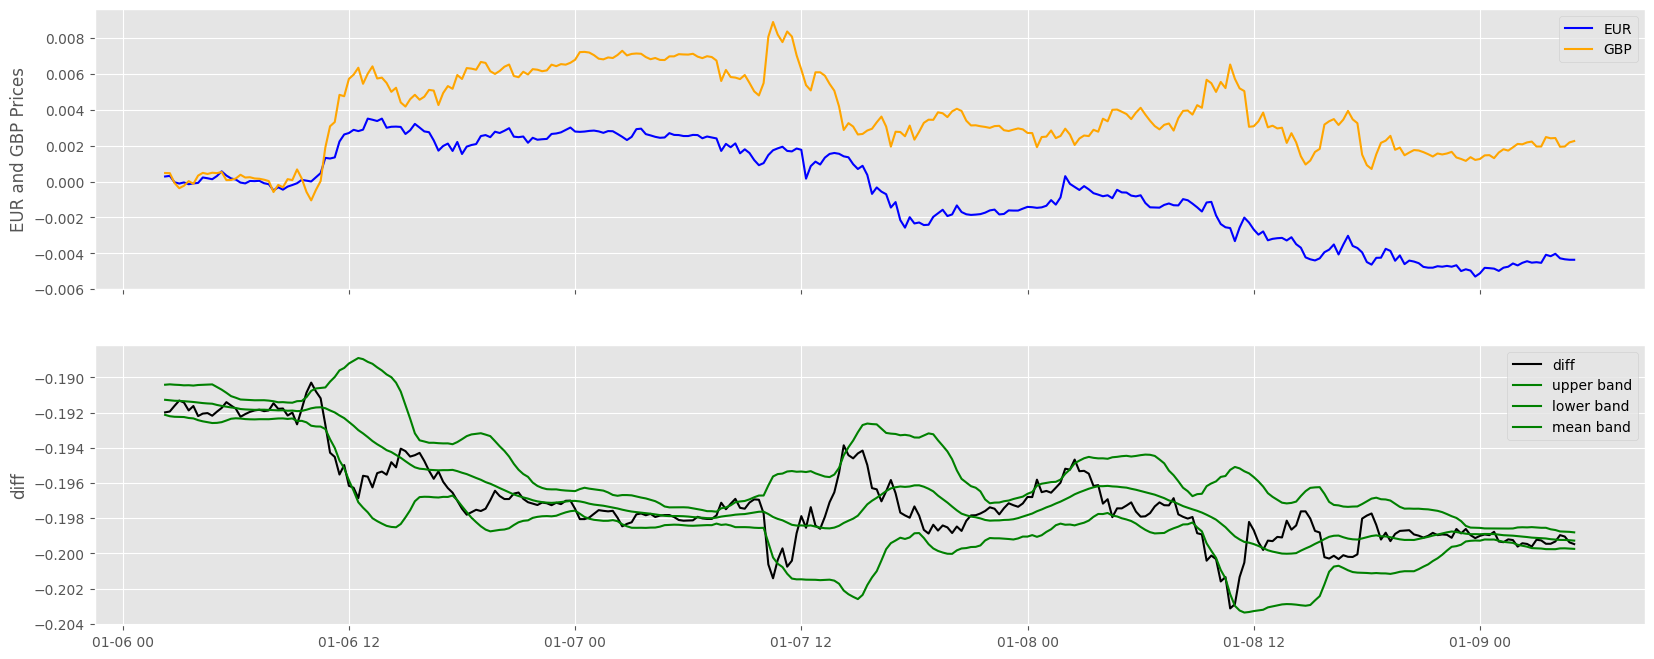

In [23]:
def plot_chart(merged_df):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), sharex=True)

    axes[0].plot(merged_df.index, merged_df['returnedf'].cumsum(),label = 'EUR', color = 'blue')
    axes[0].plot(merged_df.index, merged_df['returngdf'].cumsum(),label = 'GBP', color = 'orange')
    axes[0].legend()
    axes[0].set_ylabel('EUR and GBP Prices')


    axes[1].plot(merged_df.index, merged_df['diff'], label = 'diff', color = 'black')
    axes[1].plot(merged_df.index, merged_df['upper_band'], label = 'upper band', color = 'green')
    axes[1].plot(merged_df.index, merged_df['lower_band'], label = 'lower band', color = 'green')
    axes[1].plot(merged_df.index, merged_df['diff_mean'], label = 'mean band', color = 'green')
    axes[1].legend()
    axes[1].set_ylabel('diff')

    plt.show()

plot_chart(merged_df[200:500])

<Axes: xlabel='time'>

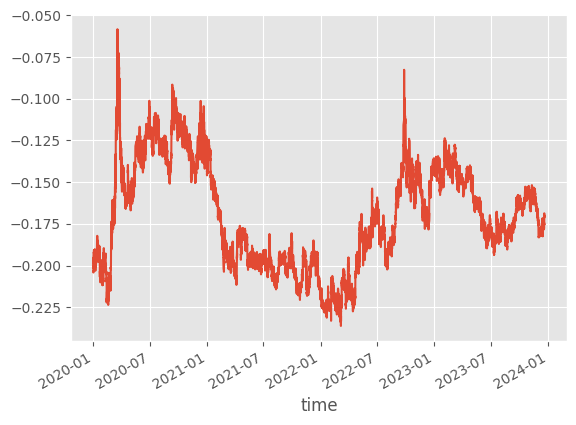

In [24]:
merged_df['diff'].plot()

# Features and strategy logic

In [11]:
df = bollinger_band(df,'close',20,2)
htf = resample_dataframe(df,'1H')
htf = htf.shift()

htf = macd(htf, "close", 12, 26, 9)
df = df.merge(htf[['macd', 'signal_line']], left_index=True, right_index=True, how='left')
df[['macd', 'signal_line']] = df[['macd', 'signal_line']].ffill() 
df = atr(df,5)
df['hour'] = df.index.hour
df.tail()

df['diff_boll_h'] = df['close'] - df['BB_H']
df['diff_boll_l'] = df['close'] - df['BB_L']
df['diff_boll_m'] = df['close'] - df['BB_M']

# Backtest

In [24]:
position = None
cumulative_profit = 0
trades = []
cost = 0.0001
"""
Ways to imporve the strategy:
1. Time adjustement
2. Multiple entries and calculating average entry price
3. adjustable stop loss and take profit during the trade
"""


for i in range(1, len(df)):
    prev_row = df.iloc[i - 1]
    current_row = df.iloc[i]
    trading_time = current_row['hour'] > 9 and current_row['hour'] < 20
    
    # Slightly relaxed Long Entry Condition
    long_entry =  current_row['prediction'] == 1 and current_row['signal_line'] > 0 and current_row['macd'] > current_row['signal_line'] and current_row['low'] < current_row['BB_L'] and current_row['close'] > current_row['BB_L']
    short_entry = current_row['prediction'] == -1 and current_row['signal_line'] < 0 and current_row['macd'] < current_row['signal_line'] and current_row['high'] > current_row['BB_H'] and current_row['close'] < current_row['BB_H']


    #long_exit = current_row['Close'] > current_row['MA']
    #short_exit =  current_row['Close'] < current_row['MA']


    # Check for long entry condition
    if position is None and long_entry:
        entry_price = current_row['close']+cost
        entry_time = df.index[i]  
        tp_price = entry_price + current_row['ATR'] * 5
        sl_price = entry_price - current_row['ATR'] * 3
        position = 'long'
    
    #elif position == 'long' and not (current_row['low'] < sl_price or current_row['high'] > tp_price) and current_row['close'] > entry_price:
    #    sl_price = current_row['close'] - current_row['ATR'] * 3 


    # Check for long exit condition
    elif position == 'long' and (current_row['low'] < sl_price or current_row['high'] > tp_price):
        if current_row['low'] < sl_price and current_row['high'] > tp_price:
            if current_row['low_time'] < current_row['high_time']:
                exit_price = sl_price
            elif current_row['high_time'] < current_row['low_time']:
                exit_price = tp_price
        elif current_row['high'] > tp_price:
            exit_price = tp_price
        elif current_row['low'] < sl_price:
            exit_price = sl_price
        # else if I have exit condition
        #else:
            #exit_price = current_row['close']

        exit_time = df.index[i]  # Capturing the exit time
        pnl = exit_price - entry_price
        cumulative_profit += pnl
        trades.append({'Type': 'Long', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None

    # Check for short entry condition
    elif position is None and short_entry:
        entry_price = current_row['close'] - cost
        entry_time = df.index[i] 
        tp_price = entry_price - current_row['ATR'] * 5
        sl_price = entry_price + current_row['ATR'] * 3
        position = 'short'

    #elif position == 'short' and not (current_row['high'] > sl_price or current_row['low'] < tp_price) and current_row['close'] < entry_price :
    #    sl_price = current_row['close'] + current_row['ATR'] * 3



    # Check for short exit condition
    elif position == 'short' and (current_row['high'] > sl_price or current_row['low'] < tp_price):
        if current_row['high'] > sl_price and current_row['low'] < tp_price:
            if current_row['high_time'] < current_row['low_time']:
                exit_price = sl_price
            elif current_row['low_time'] < current_row['high_time']:
                exit_price = tp_price
        elif current_row['high'] > sl_price:
            exit_price = sl_price
        elif current_row['low'] < tp_price:
            exit_price = tp_price
        # else if I have exit condition
        #else:
           #exit_price = current_row['close']
 
        exit_time = df.index[i]  # Capturing the exit time
        pnl = entry_price - exit_price
        cumulative_profit += pnl
        trades.append({'Type': 'Short', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None
        
# Convert the list of dictionaries to a DataFrame
history_book = pd.DataFrame(trades)


In [25]:
history_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Type               881 non-null    object        
 1   Entry Price        881 non-null    float64       
 2   Exit Price         881 non-null    float64       
 3   Entry Time         881 non-null    datetime64[ns]
 4   Exit Time          881 non-null    datetime64[ns]
 5   PnL                881 non-null    float64       
 6   Cumulative Profit  881 non-null    float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 48.3+ KB


In [26]:
calculate_performance_metrics(history_book)

{'Start Time': '2020-01-02 05:30:00',
 'End Time': '2023-12-20 07:45:00',
 'Win Rate (%)': 0.36,
 'Maximum Drawdown (pips)': 0.1866,
 'Average Drawdown (pips)': 0.0706,
 'Maximum Drawdown Duration': '1190 days 21:15:00',
 'Average Drawdown Duration': '125 days 09:19:05',
 'Total Number of Trades': 881,
 'Buy Count': 438,
 'Sell Count': 443,
 'Total Profit (pips)': -214.42,
 'Average Time in Trade': '0 days 15:18:48',
 'Average win': 0.004,
 'Average loss': -0.0023}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


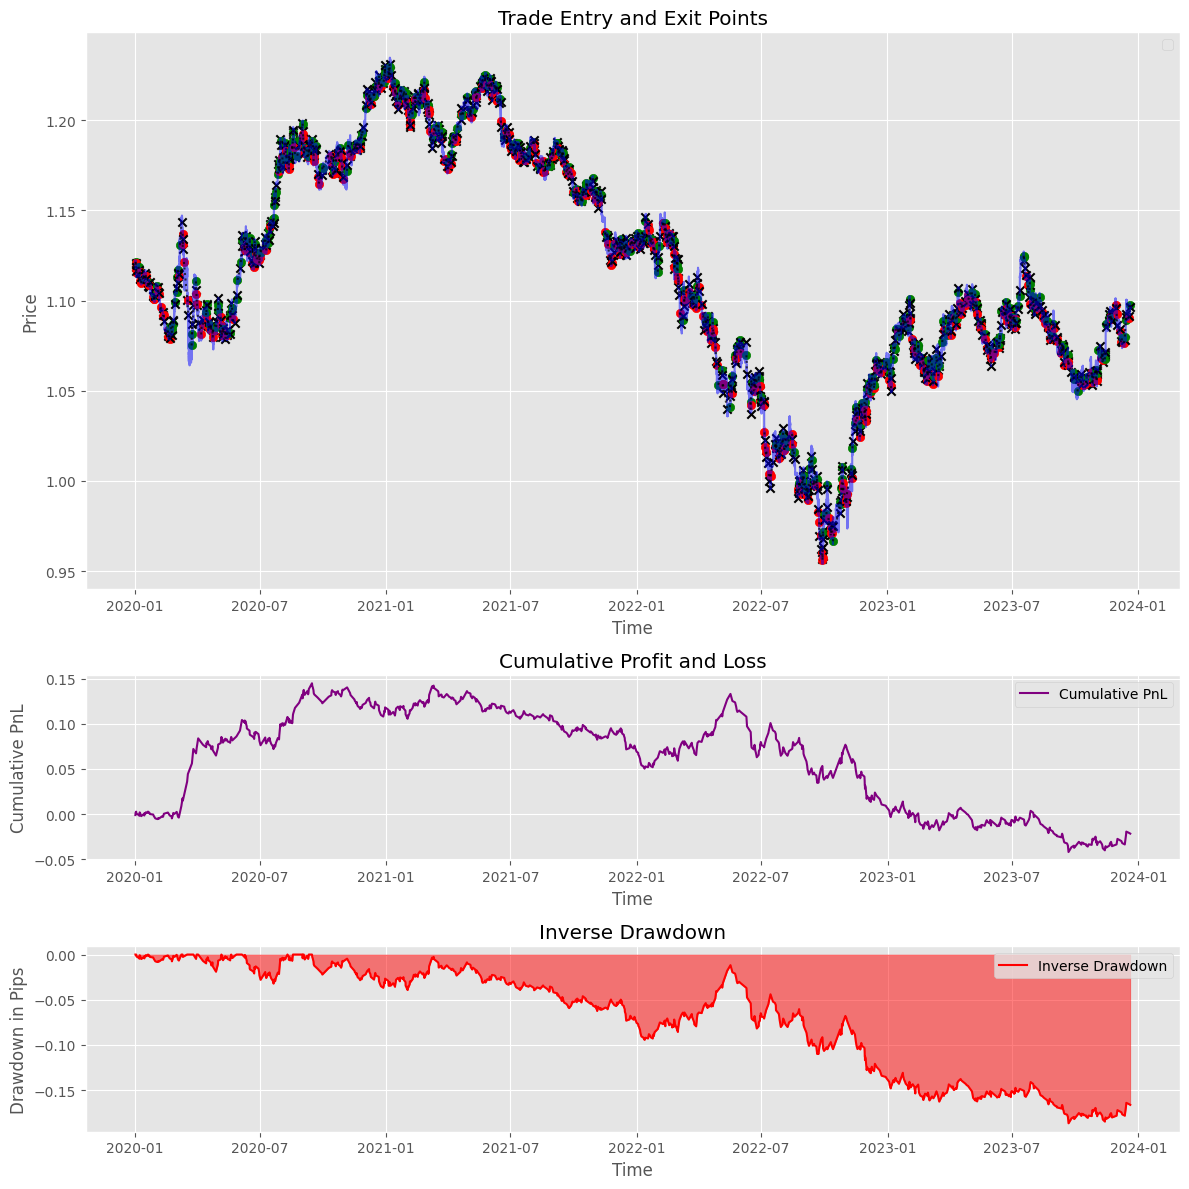

In [27]:
plot_trades(history_book,df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


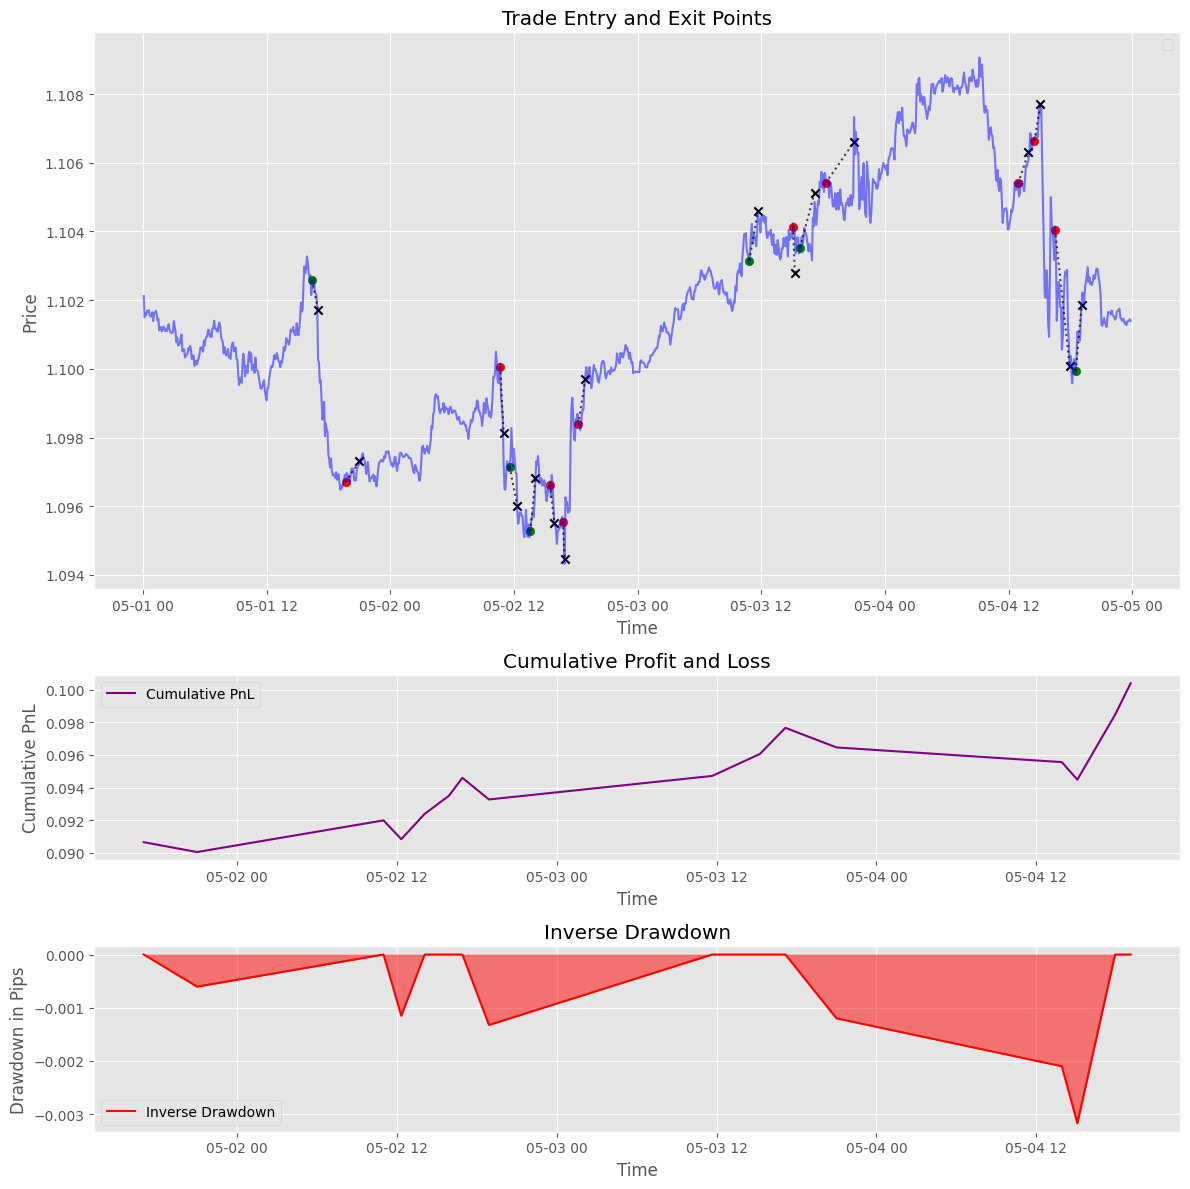

In [10]:
plot_trades(history_book,df,'2023-05-01','2023-05-05')

In [16]:
history_book

,Type,Entry Price,Exit Price,Entry Time,Exit Time,PnL,Cumulative Profit
0,Long,1.06808,1.067712,2023-01-02 10:55:00,2023-01-02 15:45:00,-0.000368,-0.000368
1,Long,1.06814,1.067804,2023-01-02 16:25:00,2023-01-02 16:50:00,-0.000336,-0.000704
2,Short,1.06678,1.065436,2023-01-02 18:10:00,2023-01-02 18:25:00,0.001344,0.000640
3,Short,1.06595,1.065660,2023-01-02 19:05:00,2023-01-02 21:55:00,0.000290,0.000930
4,Short,1.05533,1.052966,2023-01-03 11:40:00,2023-01-03 12:55:00,0.002364,0.003294
...,...,...,...,...,...,...,...
889,Short,1.09794,1.099044,2023-12-21 14:00:00,2023-12-21 15:30:00,-0.001104,0.212520
890,Short,1.09900,1.099836,2023-12-21 15:55:00,2023-12-21 21:40:00,-0.000836,0.211684
891,Long,1.10021,1.101836,2023-12-22 10:25:00,2023-12-22 12:25:00,0.001626,0.213310
892,Long,1.10252,1.103282,2023-12-22 13:50:00,2023-12-22 14:25:00,0.000762,0.214072
